# Northern Atlantic Oscillation

In [19]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date
import pandas as pd
import gdal as gdl
import matplotlib.mlab as ml
import cartopy.crs as ccrs

In [20]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)

In [21]:
db = mg.ECMWF
db.collection_names()

['system.indexes',
 'ERAINT_grid',
 'ERAINT_lores_grid',
 'ERAINT_lores_monthly_anom',
 'ERAINT_monthly',
 'ERAINT_lores_monthly']

In [22]:
ERA_vers = 'lores'
if (ERA_vers == 'hires'):
    col_dat = 'ERAINT_monthly'
    col_anom = 'ERAINT_monthly_anom'
    col_grid = 'ERAINT_grid'
    resolution = 0.25
elif (ERA_vers == 'lores'):
    col_dat = 'ERAINT_lores_monthly'
    col_anom = 'ERAINT_lores_monthly_anom'
    col_grid = 'ERAINT_lores_grid'
    resolution = 2.5

# Query grid cell ids for the NAO regions

"The NAO index is defined here as the difference between the SLP anomalies averaged over the domains of (50°W–10°E, 25–55°N) and (40°W–20°E, 55–85°N). This is referred as the “ERA-Interim Domain-based” definition." (see Wang et al., 2017)

In [23]:
con_grid = db[col_grid]
fo = con_grid.find_one()
pprint(fo)

{'_id': ObjectId('5a1882228cb6b815bce38f92'),
 'id_grid': 1,
 'loc': {'coordinates': [-180.0, 90.0], 'type': 'Point'}}


In [24]:
poly1 = [list(reversed([ [-50,25], [-50,55], [10,55],[ 10,25], [-50,25]]))]
poly2 = [list(reversed([ [-40, 55], [-40, 85], [20, 85], [20, 55], [-40, 55]]))]
def getGridIds(this_polygon):
    geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": this_polygon
                   }
               }}}

    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df
grid_df1 = getGridIds(poly1)
grid_ids1 = grid_df1.id_grid.values
grid_df2 = getGridIds(poly2)
grid_ids2 = grid_df2.id_grid.values
len(grid_ids1)

306

## Were are these grid cells ?

In [25]:
def createRasDF(this_grid_df, this_val):
    ras_df = this_grid_df.assign(
        lon = list(map(lambda x: x[0]['coordinates'][0], this_grid_df[['loc']].values)),
        lat = list(map(lambda x: x[0]['coordinates'][1], this_grid_df[['loc']].values)),
        val = this_val).pipe(lambda x: x[['lon', 'lat', 'val']])
    return(ras_df)

ras_df1 = createRasDF(this_grid_df = grid_df1, this_val = 1)
ras_df2 = createRasDF(this_grid_df = grid_df2, this_val = -1)
ras_df = pd.concat([ras_df1, ras_df2])

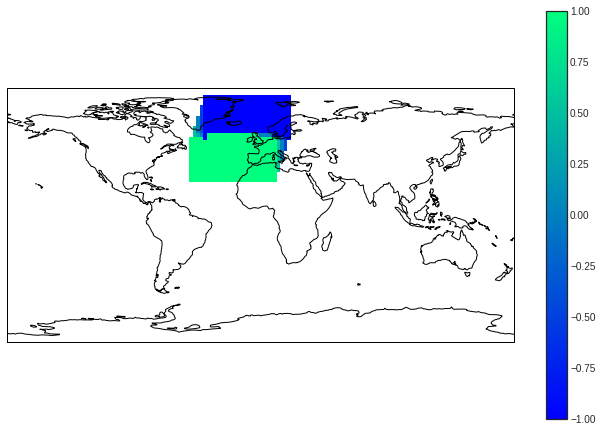

In [26]:
this_ras_df = ras_df
lons = np.arange(start=-180, stop=180+1, step=resolution)
lats = np.arange(start=-90, stop=90+1, step=resolution)
this_field = ml.griddata(x = this_ras_df.lon.values,
                 y = this_ras_df.lat.values,
                 z = this_ras_df.val.values,
                 xi = lons,
                 yi = lats,
                 interp='linear')
# Plot itself
this_proj = ccrs.PlateCarree()#ccrs.Orthographic(0, 90)
fig = plt.figure(figsize=(25, 25))
ax = plt.subplot(1, 2, 1, projection=this_proj)
ax.coastlines(zorder=3)
img_proj = ccrs.PlateCarree()
img_extent = (-180, 180, -90, 90)
im = ax.imshow(this_field, 
               transform=img_proj,
               extent=img_extent, 
               origin='lower', 
               zorder=2,
               cmap='winter')
plt.colorbar(im, orientation='vertical',ticklocation='auto', shrink=0.3)
plt.show()

## Create NAO Time Series

In [27]:
con_anom = db[col_anom]
fo = con_anom.find_one()
pprint(fo)

{'_id': ObjectId('5a46876b8cb6b8108790f64a'),
 'al': -2.7755575615628914e-17,
 'blh': 17.16410963120117,
 'ci': 0.00479535363874195,
 'd2m': -1.381832545858515,
 'date': datetime.datetime(1979, 3, 1, 0, 0),
 'hcc': -0.003499210088334481,
 'id_grid': 1,
 'ie': 0.0,
 'ishf': -6.802686632924173,
 'istl1': -0.6554408397386169,
 'lcc': 0.09395961846049472,
 'mcc': 0.1201171896552547,
 'month': 3,
 'msl': -1286.3445712374814,
 'si10': -0.9742091376525144,
 'skt': -0.70064309868485,
 'sp': -1285.586603789896,
 'sst': -1.7053025658242404e-13,
 'stl1': -0.6713863041083243,
 't2m': -1.5088453972467164,
 'u10': -3.921264344805355,
 'v10': 2.6433083071635384,
 'year': 1979,
 'z70': -1312.067142538639}


In [28]:
#?grid_df1.assign()
#?grid_df1.pipe()
#?grid_df1.apply
#?grid_df1.transform
#?grid_df1.groupby

this_grid_ids = grid_ids1
this_msl = con_anom.aggregate(pipeline=[
        {"$match": {"id_grid": {"$in": this_grid_ids.tolist()}}},
        {"$group": {"_id": "$date", "mean": {"$avg": "$msl"} }},
        {"$project": {"date": "$_id", 
                      "_id": 0, 
                      "msl": "$mean"}}])
this_msl_df = pd.DataFrame(list(this_msl))
this_msl_df = this_msl_df.assign(
    month=list(map(lambda x: x.month, this_msl_df.date)),
    wyear=list(map(lambda x: setWinterYear(x), this_msl_df.date)) ).pipe(
    lambda df: df.query("month in [12, 1, 2]") ).pipe(
    lambda df: df.groupby("wyear").mean()
)
this_msl_df.head()

In [29]:
def setWinterYear(date): # December belong to next year's winter
    mon=date.month
    yr=date.year
    if mon == 12:
        res = yr+1
    else:
        res = yr
    return res

def getMSL(this_grid_ids):
    this_msl = con_anom.aggregate(pipeline=[
        {"$match": {"id_grid": {"$in": this_grid_ids.tolist()}}},
        {"$group": {"_id": "$date", "mean": {"$avg": "$msl"} }},
        {"$project": {"date": "$_id", 
                      "_id": 0, 
                      "msl": "$mean"}}])
    this_msl_df = pd.DataFrame(list(this_msl))
    this_msl_df = this_msl_df.assign(
            month=list(map(lambda x: x.month, this_msl_df.date)),
            wyear=list(map(lambda x: setWinterYear(x), this_msl_df.date)) ).pipe(
    lambda df: df.query("month in [12, 1, 2]") ).pipe(
    lambda df: df.groupby("wyear").mean().reset_index())
    return this_msl_df
    
msl1_df = getMSL(this_grid_ids = grid_ids1).rename(columns={'msl': 'msl1'})
msl2_df = getMSL(this_grid_ids = grid_ids2).rename(columns={'msl': 'msl2'})
msl1_df.head()

   wyear        msl1  month
0   1979  513.131265    1.5
1   1980  152.977452    5.0
2   1981 -444.747185    5.0
3   1982  336.279706    5.0
4   1983 -342.535287    5.0

In [30]:
msl_df = pd.merge(msl1_df, msl2_df)
msl_df = msl_df.assign(NAO = msl_df.msl2-msl_df.msl1).sort_values('wyear', ascending=True).reset_index(drop=True)
msl_df.head()

   wyear        msl1  month        msl2          NAO
0   1979  513.131265    1.5 -566.234459 -1079.365724
1   1980  152.977452    5.0  -98.370800  -251.348252
2   1981 -444.747185    5.0  117.529424   562.276609
3   1982  336.279706    5.0 -377.140170  -713.419876
4   1983 -342.535287    5.0  378.676276   721.211563

## Time Series Plot

In [31]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True) # for live plot
pd.set_option('display.notebook_repr_html', False)
%matplotlib inline
plt.style.use('seaborn-white')

In [32]:
# Plot ts
data = [go.Scatter(x=msl_df['wyear'], y=msl_df['NAO'] )]
py.iplot(data, filename='pandas-time-series')